# Exercise 7 - Mersenne Twister

In this exercise, we will build one of the most widely used pseudo-random number generators (PRNG) from scratch.
We will then compare it to the infamous RANDU generator with a serial test.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        01.01.2023
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=34630)

### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions, classes and other objects with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# The Mersenne Twister

The [Mersenne Twister](https://dl.acm.org/doi/10.1145/272991.272995) is a widely used pseudo-random number generator (PRNG).
It is at the core of Pythons random module and one of the generators available to use in numpy. It is widely used for its relative simplicity and its extremely long period of $2^{19937}-1$ (a [Mersenne prime](https://en.wikipedia.org/wiki/Mersenne_prime), hence the name).

In its most famous variant, the MT19937, we generate 32 bit integers by scrambling bit strings.

The following 12 parameters determine the version of the Mersenne Twister:

- $w$... maximum length of a bitstring
- $n$... size of internal state
- $r$... separation point of bitstrings
- $f$... constant used in initialization
- $m$... offset used in twist operation
- $a$... constant used in twist operation
- $u$... constant used in tempering
- $s$... constant used in tempering
- $b$... constant used in tempering
- $t$... constant used in tempering
- $c$... constant used in tempering
- $l$... constant used in tempering

With the following tasks we will gradually introduce each one of them.

## Number Representation

The Mersenne Twister only deals with integers of a fixed bit length $w$.
Hence we need to check at every step if we still have such an integer. If not, we only use the lowest $w$ bits.

### Task 1

Implement the function `to_intw` that takes a number and prunes it to its lowest $w$ bits.

Test your function on some base cases.

In [2]:
def to_intw(number: int, w: int) -> int:
    '''
    Prunes the binary string of a number to its lowest w bits.

    @Params:
        number... number to be pruned
        w... maximum length of a bitstring

    @Returns:
        pruned number
    '''

    return number & ((1 << w) - 1)


# TODO: test
assert to_intw(3, 0) == 0
assert to_intw(0, 0) == 0
assert to_intw(3, 1) == 1
assert to_intw(3, 2) == 3
assert to_intw(4, 3) == 4
assert to_intw(2**33 - 2, 32) == 2**32 - 2


A core operation in the Mersenne Twister is the combination of bitstrings:

Given two bitstrings $b_1$ and $b_2$ as well as a position $r$, the operation takes the highest $r$ bits from $b_1$ and the rest from $b_2$.

As an example for $r=4$: 
\begin{align}
b_1 &= 1011|01001\\
b_2 &= 1101|11101\\
\rightarrow comb(b_1, b_2)&=1011|11101
\end{align}

### Task 2

Implement the function `combine` that performs the combination as described above.

Make sure that the resulting number has $w$ bits again and test your function on some base cases.

In [3]:
def combine(number1: int, number2: int, r: int, w: int) -> int:
    '''
    Combines the bitstrings of two numbers to a new number.

    @Params:
        number1... number for leftmost bits
        number2... numer for rightmost bits
        r... position at which the bitstrings are separated
        w... maximum length of a bitstring

    @Returns:
        number of combined bitstrings
    '''

    mask_high = ((1 << r) - 1) << (w - r)
    mask_low = (1 << w - r) - 1
    return (number1 & mask_high) | (number2 & mask_low)

assert combine(3, 12, 2, 4) == 0
assert combine(12, 3, 2, 4) == 15
assert combine(12, 3, 0, 4) == 3
assert combine(12, 3, 4, 4) == 12

## Initialization

Internally, the Mersenne Twister holds a list of $n$ integers. We refer to this list as the state of the PRNG.
When asked for a random number, the Mersenne Twister uses one of the numbers in the state.

How is this list $[x_i]_{i=0,\dots,n-1}$ initialized? 

Given a seed, we set $x_0:=$ seed, and then compute
\begin{equation}
x_i = f\cdot\left(x_{i-1}\oplus(x_{i-1}>> (w-2))\right) + i\,,
\end{equation}
for $i>0$.

Here $\oplus$ denotes bitwise XOR and $>>$ denotes bitwise shift to right. The constant $f$ is one of the parameters.

### Task 3

Implement the `init_state` function. 

Make sure that each of the resulting numbers has $w$ bits again.

As a reference, the initialization for the settings of MT19937
- $n=624$
- $f=1812433253$
- $w=32$

with a seed of $0$ should start with the following numbers:
```
0, 1, 1812433255, 1900727105, 1208447044, 2481403966, ...
```


In [4]:
def init_state(seed: int, n: int, f: int, w: int) -> list[int]:
    '''
    Given a seed, creates a state of n numbers.

    @Params:
        seed... any number
        n... number of states
        f... constant
        w... maximum length of a bitstring
    '''

    state = [None] * n
    state[0] = seed
    for i in range(1, n):
        state[i] = f * (state[i - 1] ^ (state[i - 1] >> (w - 2))) + i
        state[i] = to_intw(state[i], w)
    return state

# TODO: test
n = 624
f = 1812433253
w = 32
seed = 0
state = init_state(seed, n, f, w)
assert state[:6] == [0, 1, 1812433255, 1900727105, 1208447044, 2481403966]

## Twist

Whenever we have used all of the numbers in the state (and after initialization), we have to generate a new state. This operation is referred to as *twist*

The twist iteratively recalculates every number $x_k$ in the state with FOUR steps.

Let $x_k$ be the $k$-th entry from the state, $x_k^{(i)}$ be the intermediate result from step $i$, $x_k^{(0)} := x_k$.

1. $x_k^{(1)} = \text{combine}(x_k^{(0)}, x_{k+1})$
2. $x_k^{(2)} = x_k^{(1)} >> 1$
3. rightmost (lowest) bit of $x_k^{(2)}$ = 1?
    - Yes: $x_k^{(3)} = x_k^{(2)}\oplus a$
    - No: $x_k^{(3)} = x_k^{(2)}$
    
    
4. $x_k^{(4)} = x_k^{(3)}\oplus x_{k+m}$

Indices start from 0 again after they exceed $n-1$.

### Task 4

Implement the `twist` function.

As a reference, if we twist the initialized state from Task 3 with
- $m = 397$
- $r = 1$
- $a = 2567483615$

we get the following numbers
```
145341901, 1093594115, 4143945099, 2709361018, 3634778323, 1907852202, ...
```

In [5]:
def twist(state: list[int], w: int, m: int, r: int, a: int) -> list[int]:
    '''
    Produces a new state.

    @Params:
        state... list of numbers
        w... maximum length of a bitstring
        m... offset for last XOR
        r... position at which the bitstrings are separated
        a... constant

    @Returns:
        new state
    '''

    n = len(state)
    new_state = [None] * n
    # step 1
    for i in range(n):
        new_state[i] = combine(state[i], state[(i + 1) % n], r, w)
    # step 2
    for i in range(n):
        new_state[i] = new_state[i] >> 1
    # step 3
    for i in range(n):
        if new_state[i] & 1:
            new_state[i] = new_state[i] ^ a
    # step 4
    for i in range(n):
        new_state[i] = new_state[i] ^ state[(i + m) % n]
    return new_state


# TODO: test
m = 397
r = 1
a = 2567483615
new_state = twist(state, w, m, r, a)
assert new_state[:6] == [145341901, 1093594115, 4143945099, 2709361018, 3634778323, 1907852202]

## Tempering

If the Mersenne Twister is asked for a random number, it takes a number from its state and mixes it up. This step is called *tempering*.

Tempering is a sequence of four steps:
Let $x$ be the selected number from the state, $x^{(i)}$ be the intermediate result from step $i$, $x^{(0)} := x$.

1. $x^{(1)} = x^{(0)}\oplus(x^{(0)} >> u)$
2. $x^{(2)} = x^{(1)}\oplus\left((x^{(1)} << s)\otimes b\right)$
3. $x^{(3)} = x^{(2)}\oplus\left((x^{(2)} << t)\otimes c\right)$
4. $x^{(4)} = x^{(3)}\oplus(x^{(3)} >> l)$

where $\otimes$ is the bitwise AND, $\oplus$ is the bitwise XOR, $<<$ and $>>$ denote bitshifts to the left and right, respectively.

### Task 5

Implement the `tempering` function. 

As a reference, if we temper the first number of the twisted state from Task 4 with
- $u = 11$
- $s = 7$
- $b = 2636928640$
- $t = 15$
- $c = 4022730752$
- $l = 18$

we get the number
```
1927864384
```

In [6]:
def tempering(number: int, u: int, s: int, b: int, t: int, c: int, l: int, w: int) -> int:
    '''
    Mixes up a selected number.

    @Params:
        number... number of state to be mixed up
        u... number of bitshifts to right in step 1
        s... number of bitshifts to left in step 2
        b... constant in step 2
        t... number of bitshifts to left in step 3
        c... constant in step 3
        l... number of bitshifts to right in step 4
        w... maximum length of a bitstring
    '''

    x = number
    x ^= x >> u
    x ^= (x << s) & b
    x = to_intw(x, w)
    x ^= (x << t) & c
    x = to_intw(x, w)
    x ^= x >> l
    return x


# TODO: test
u = 11
s = 7
b = 2636928640
t = 15
c = 4022730752
l = 18
assert tempering(new_state[0], u, s, b, t, c, l, w) == 1927864384


## Putting everything together

Now we have everything to build the MT19937.

After initializing and twisting the state, we can generate samples by

- iterating trough the state with a stepsize of 2
- whenever we are at index 0 again, perform a twist first

We will put all this functionality in a class.

### Task 6

Implement the following class by reusing your implementations from before.\
Here parameters are set to the default parameters for MT19937.

The `sample` function should return a float in $[0, 1]$. 
This can be achived by dividing the tempered number by the largest possible number that can be generated.

Use your sampler to produce 10 samples with a seed of 12345.

In [7]:
class MT_19937:
    def __init__(self, seed: int):
        # general params
        self.w = 32  # word length -> range of resulting numbers
        self.n = 624  # number of recurrence
        self.normalization_constant = 2**w - 1

        # initialization
        self.seed = seed
        self.f = 1812433253

        # twist
        self.m = 397  # offset used in recurrence
        self.r = 1  # seperation point of bit sequence
        self.a = 0x9908b0df  # used for twist if last bit = 1

        # tempering
        self.u = 11
        self.s = 7
        self.b = 0x9D2C5680
        self.t = 15
        self.c = 0xEFC60000
        self.l = 18

        # states
        self.index = 0
        self.state = None
        self.init_state()

    def sample(self) -> float:
        '''
        Samples a float in [0, 1].
        '''

        if self.index == 0:
            self.twist()
        generated = self.tempering(self.state[self.index]) / self.normalization_constant
        self.index = (self.index + 2) % self.n
        return generated

    def to_intw(self, number: int) -> int:
        return to_intw(number, self.w)

    def combine(self, number1: int, number2: int) -> int:
        return combine(number1, number2, self.r, self.w)

    def init_state(self):
        self.state = init_state(self.seed, self.n, self.f, self.w)

    def twist(self):
        self.state = twist(self.state, self.w, self.m, self.r, self.a)

    def tempering(self, number: int) -> int:
        return tempering(number, self.u, self.s, self.b, self.t, self.c, self.l, self.w)


# TODO: sample 10 samples with seed 12345
prng = MT_19937(seed=12345)
samples = [prng.sample() for _ in range(10)]
print(samples)

[0.0758778485646187, 0.681306358818269, 0.1839188123550077, 0.20456027942815802, 0.5677250264137343, 0.5955447027449368, 0.9645145216408453, 0.35012005813189784, 0.25463405373846976, 0.6535698752043698]


### Comparison with Numpy

Numpys Mersenne Twister implementation has a different initialization routine than the original version.

However we can compare our sampler to the [legacy version of MT19937](https://numpy.org/doc/stable/reference/random/legacy.html) that has the original initialization routine.

### Task 7

Use numpys legacy implementation of MT19937 to sample 10 random floats with a seed of 12345.

In [8]:
from numpy.random import RandomState

# TODO: sample 10 samples with seed 12345
rs = RandomState(seed=12345)


np_samples = [rs.random_sample() for _ in range(10)]
print(np_samples)
print("Why is it not the exact same? Let's compare the states:")
np_state = list(rs.get_state()[1])
print(prng.state[:12])
print(np_state[:12])
print("Yeah, no idea.")

[0.9296160928171479, 0.3163755545817859, 0.18391881167709445, 0.2045602785530397, 0.5677250290816866, 0.5955447029792516, 0.9645145197356216, 0.6531770968715709, 0.7489066375339118, 0.6535698708517353]
Why is it not the exact same? Let's compare the states:
[3451587124, 4115295001, 625918259, 2835703408, 2148341571, 1571424867, 1008047323, 4182378715, 2834253016, 757466022, 1215346198, 2867824964]
[1421064939, 1816320966, 3158733292, 2835703408, 2148341571, 1571424867, 1008047323, 4182378715, 2834253016, 3022959481, 1215346198, 2867824964]
Yeah, no idea.


# Tests for Randomness

In this part of the exercise we want to compare our MT19937 to the infamous [RANDU](https://en.wikipedia.org/wiki/RANDU) PRNG.

Just to cite from Wikipedia:

    "IBM's RANDU is widely considered to be one of the most ill-conceived random number generators ever designed"
    
and we are about to find out why.


RANDU is defined by the recurrence
\begin{equation}
x_{i+1} = (65539\cdot x_i)\text{mod }2^{31}
\end{equation}

starting with a seed ($=: x_0$) we can apply this simple recurrence function to generate a sequence of numbers.

### Task 8

Implement RANDU and sample 10 random floats with a seed of 12345.

In [9]:
class RANDU():

    def __init__(self, seed: int):
        self.x = seed
        self.multiplier = 65539
        self.modulo = 2**31

    def sample(self) -> float:
        '''
        Samples a float in [0, 1].
        '''

        self.x = (self.multiplier * self.x) % self.modulo
        return self.x / (self.modulo - 1)


# TODO: sample 10 samples with seed 12345
randu = RANDU(seed=12345)
randu_samples = [randu.sample() for _ in range(10)]
print(randu_samples)

[0.3767567478943415, 0.26048874913737585, 0.17212176470650442, 0.6883318469339664, 0.5808951983139362, 0.29038456887490327, 0.5142506302866389, 0.4720426618457039, 0.2040002994257958, 0.9756178418060848]


## Serial Test

The serial test is a test to determine whether iid drawn points in the $d$-dimensional hypercube are likely to have been generated by a uniform distribution.

If we seperate the hypercube into $k^d$ bins of equal size, then we expect roughly the same amount of points in each bin.

<div>
<img src="images/hypercube.png" width="400"/>
</div>


In other words, we expect the statistic
\begin{equation}
V = \sum_{i=1}^{k^d}\left(b_i - \frac{n}{k^d}\right)^2
\end{equation}
to be low ($b_i$ are the counts in bin $i$).

Since $V$ is $\chi^2$- distributed we can now ask: What is the probability that a uniform distribution would produce a greater $V$? If this probability is low then our samples are not likely to have been generated by a uniform distribution.

This question is also known as the $\chi^2$- Test.
In Python this test is implemented in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html).


### Task 9

Implement the `serial_test` function that takes an array of floats in $[0, 1]$ and then 
1. creates a dataset of $d$-dimensional points
2. counts the number of points in each of the $k^d$ bins
3. returns the p- value of the $\chi^2$-test

Test your function on RANDU and MT19937 for $d=3$ and $k=30$ if you expect 5 points per bin.\
Repeat this experiment 10 times and report the average p-value.

We choose a confidence level of 95%; that is, we will reject the null hypothesis (our data is uniformly distributed) in favor of the alternative if the p-value is less than 0.05.

Inspect the bins to see why RANDU scores so bad.

p-values:
mt19937: 0.60
randu: 0.63


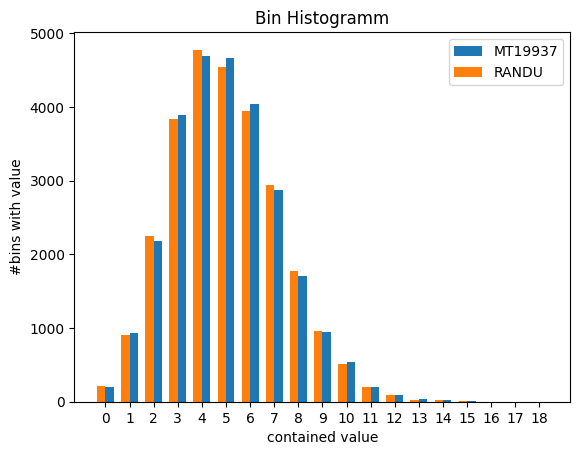

In [34]:
from collections import Counter
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt


def serial_test(samples: np.ndarray, d: int, k: int) -> tuple[float, np.ndarray]:
    '''
    Returns the p-value of a chi^2 test on the d dimensional hypercube with k^d categories.

    @Params:
        samples... array of floats generated by PRNG
        d... dimension of points
        k... number of bins along each dimension

    @Returns:
    tuple containing
        p- value of chi^2 test if we view the k^d bins as categories.
        bins as numpy array with counts
    '''

    # create dataset of d-dimensional points (just cut it into smaller pieces basically)
    dataset = np.array(np.split(samples, d)).T
    # create bins
    bin_shape = tuple([k] * d)
    bins = np.zeros(bin_shape, dtype=np.uint)
    # multiply every dimension by k to find out in which bin each sample is
    in_bin = np.floor(dataset * k).astype(dtype=np.uint8)
    # if we generate a 1 (possible in [0,1] interval), we need to put it into the last bin (k - 1) instead of bin k.
    in_bin[in_bin == k] = k - 1
    # count the points in the bins
    for position in in_bin:
        bins[tuple(position)] += 1
    # convert the bins into a list again
    bins = bins.flatten()
    # do the test
    _, p_value = chisquare(bins)
    return p_value, bins


d = 3
k = 30
points_per_bin = 5
# k^d boxes, points_per_bin d-dimensional samples, d dimensions
sample_size = k**d * points_per_bin * d


def generate_samples(sampler) -> np.ndarray:
    return np.array([sampler.sample() for _ in range(sample_size)])


mt19937 = MT_19937(seed=12345)
randu = RANDU(seed=12345)

n_tests = 10
# TODO: calculate p-values
mt19937_p_value = np.average([serial_test(generate_samples(mt19937), d, k)[0] for _ in range(n_tests)])
randu_p_value = np.average([serial_test(generate_samples(randu), d, k)[0] for _ in range(n_tests)])
print(f"p-values:\nmt19937: {mt19937_p_value:.2f}\nrandu: {randu_p_value:.2f}")

# TODO: inspect bins
# 1 more time to extract the bins
_, mt19937_bins = serial_test(generate_samples(mt19937), d, k)
_, randu_bins = serial_test(generate_samples(randu), d, k)
assert np.sum(mt19937_bins) == k**d * points_per_bin
assert np.sum(randu_bins) == k**d * points_per_bin

mt19937_counts = Counter(mt19937_bins)
randu_counts = Counter(randu_bins)
assert mt19937_counts.total() == k**d
assert randu_counts.total() == k**d

mt19937_max = np.max(mt19937_bins)
randu_max = np.max(randu_bins)
max_value = max(randu_max, mt19937_max)
x_axis = np.arange(max_value + 1)
mt19937_y = [mt19937_counts[x] for x in x_axis]
randu_y = [randu_counts[x] for x in x_axis]
width = 0.35
plt.bar(x_axis + width / 2, mt19937_y, width, label="MT19937")
plt.bar(x_axis - width / 2, randu_y, width, label="RANDU")
plt.title("Bin Histogramm")
plt.xlabel("contained value")
plt.ylabel("#bins with value")
plt.xticks(x_axis)
plt.legend()
plt.show()
# NOTE: doesn't look that bad! Did i do something wrong?